# Financial and Economic Data Applications
Original from Wes McKinney (https://github.com/wesm/pydata-book/tree/1st-edition)

Updated and edited for Python circa 2018 by R. D. Slater


In [1]:
%pwd

'/home/george_sturrock/qtw'

## Signal frontier analysis
### Data Acquisition
Import libraries and download daily adjusted close stock prices and Dow Jones values.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import datetime
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
start_dt=datetime.datetime(2016,1,1)
end_dt=datetime.datetime(2018,9,15)
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

yf.pdr_override()
names=['APC', 'FB', 'NFLX', 'SPLK', 'TWTR', 'UBNT', 'WMT']
px=pdr.get_data_yahoo(tickers=names, start=start_dt, end=end_dt)['Adj Close']

djiPx=pdr.get_data_yahoo(tickers='^DJI', start=start_dt, end=end_dt)['Adj Close']

[*********************100%***********************]  7 of 7 downloaded
[*********************100%***********************]  1 of 1 downloaded


View the dataframe containing the daily adjust close stock price for each security.

In [4]:
#px = pd.read_csv('ch11/stock_px.csv')
pxSave = px
print(px.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 681 entries, 2016-01-04 to 2018-09-14
Data columns (total 7 columns):
APC     681 non-null float64
FB      681 non-null float64
NFLX    681 non-null float64
SPLK    681 non-null float64
TWTR    681 non-null float64
UBNT    681 non-null float64
WMT     681 non-null float64
dtypes: float64(7)
memory usage: 42.6 KB
None


### Data Processing
Create dataframe for daily returns for each stock.

In [ ]:
px = px.asfreq('B').fillna(method='pad')
rets = px.pct_change()

View Dow Jones daily data and Dow Jones daily returns.

In [6]:
print(djiPx.describe())
djiRets = djiPx.pct_change()
print(djiRets.describe())

count      681.000000
mean     21188.352622
std       2995.433543
min      15660.179688
25%      18325.070313
50%      20975.779297
75%      24264.300781
max      26616.710938
Name: Adj Close, dtype: float64
count    680.000000
mean       0.000648
std        0.007408
min       -0.046049
25%       -0.002307
50%        0.000748
75%        0.004188
max        0.028445
Name: Adj Close, dtype: float64


Create dataframe for total average daily price and average daily return of the entire portfolio.

In [5]:
pxTot = px.mean(axis=1)
print(pxTot.describe())
pxTotRet = pxTot.pct_change()
print(pxTotRet.describe())

count    681.000000
mean      87.572863
std       25.207392
min       51.500724
25%       68.355967
50%       78.693594
75%      106.116972
max      145.653262
dtype: float64
count    680.000000
mean       0.001240
std        0.013226
min       -0.060180
25%       -0.004683
50%        0.001276
75%        0.008663
max        0.052507
dtype: float64


In [7]:
plt.close('all')

### Calculations
Calculate and plot the cumulative returns of each stock.

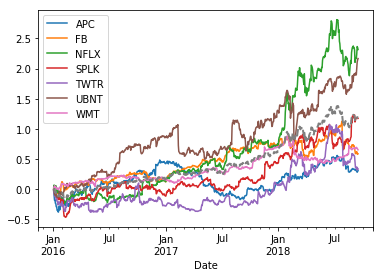

In [32]:

((1 + rets).cumprod() - 1).plot()
((1 + pxTotRet).cumprod() - 1).plot(linestyle='--', label="Portfolio", linewidth = 2)

Cummulative Return for the Portfolio

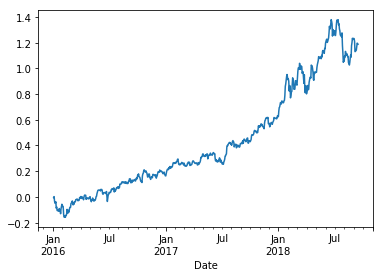

In [50]:
((1 + pxTotRet).cumprod() - 1).plot()

#### Moving Window Averages

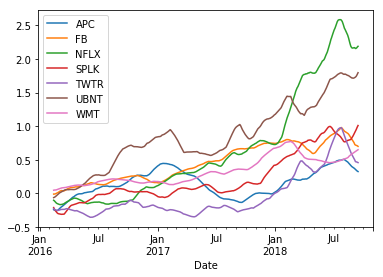

In [29]:
#30 Day Rolling Moving Window Average
((1 + rets).cumprod() - 1).rolling(30).mean().plot()

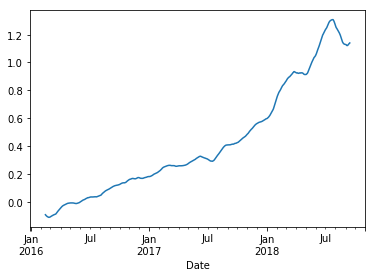

In [52]:
#30 Day Rolling Moving Widow Average for the Portfolio
((1 + pxTotRet).cumprod() - 1).rolling(30).mean().plot()

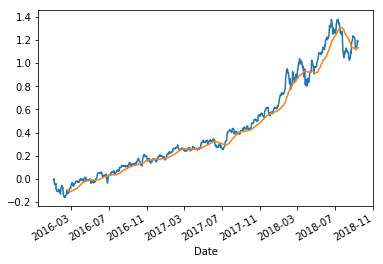

In [20]:
#Daily Portfolio to 30 Day Rolling Window Average
((1 + pxTotRet).cumprod() - 1).plot()
((1 + pxTotRet).cumprod() - 1).rolling(30).mean().plot()

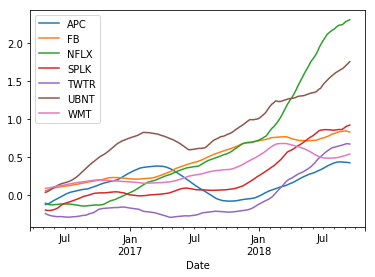

In [30]:
#90 Day Rolling Moving Window Average
((1 + rets).cumprod() - 1).rolling(90).mean().plot()

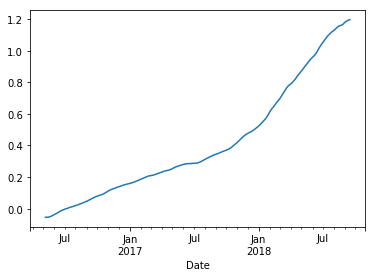

In [53]:
#90 Day Rolling Moving Widow Average for the Portfolio
((1 + pxTotRet).cumprod() - 1).rolling(90).mean().plot()

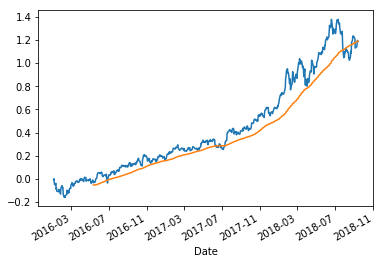

In [21]:
#Daily Portfolio to 90 Day Rolling Window Average
((1 + pxTotRet).cumprod() - 1).plot()
((1 + pxTotRet).cumprod() - 1).rolling(90).mean().plot()

#### Exponentially Weighted Functions

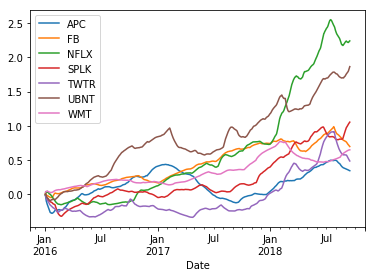

In [31]:
#30 Day Exponentially Weighted Function
((1 + rets).cumprod() - 1).ewm(span=30).mean().plot()

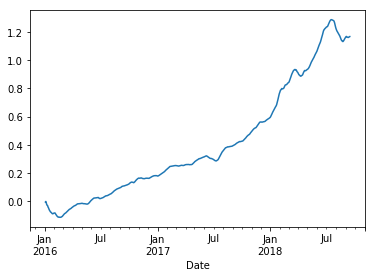

In [55]:
#30 Day Exponentially Weighted Function for the Portfolio
((1 + pxTotRet).cumprod() - 1).ewm(span=30).mean().plot()

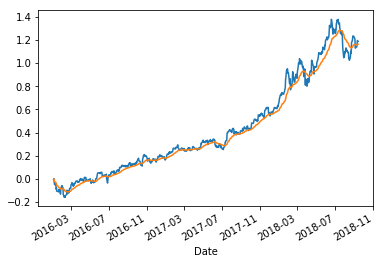

In [22]:
#Compare Daily Portfolio Returns to 30 Day Exponentially Weighted Function for the Portfolio
((1 + pxTotRet).cumprod() - 1).plot()
((1 + pxTotRet).cumprod() - 1).ewm(span=30).mean().plot()

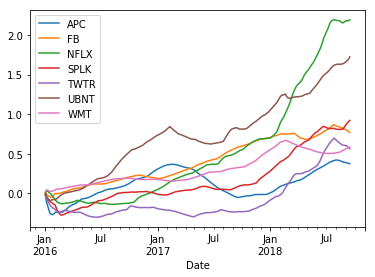

In [32]:
#90 Day Exponentially Weighted Function
((1 + rets).cumprod() - 1).ewm(span=90).mean().plot()

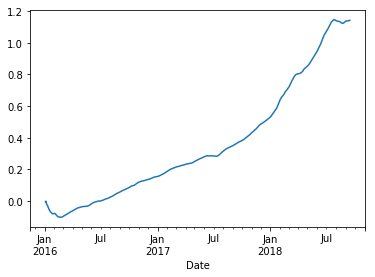

In [56]:
#90 Day Exponentially Weighted Function for the Portfolio
((1 + pxTotRet).cumprod() - 1).ewm(span=90).mean().plot()

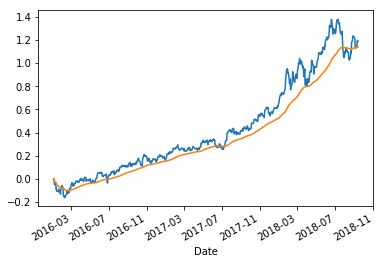

In [24]:
#Compare Daily Portfolio Returns to 90 Day Exponentially Weighted Function for the Portfolio
((1 + pxTotRet).cumprod() - 1).plot()
((1 + pxTotRet).cumprod() - 1).ewm(span=90).mean().plot()

#### Binary Moving Window Function

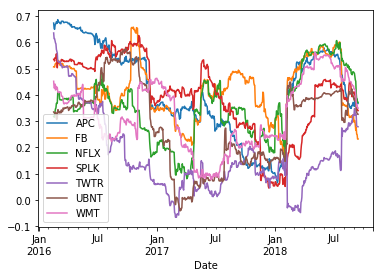

In [30]:
#Correlation of individual stocks to Dow Jones
corr = rets.rolling(120, min_periods=30).corr(djiRets)
corr.plot()

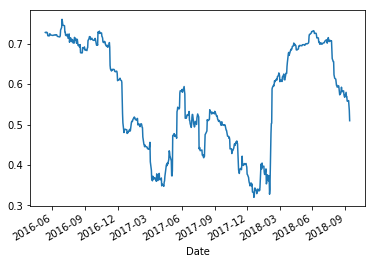

In [41]:
#Correlation of portfolio to Dow Jones
corr = pxTotRet.rolling(120, min_periods=90).corr(djiRets)
corr.plot()

In [42]:
#Pearson's R for Portfolio Returns and Dow Jones Returns
from scipy import stats
print("Pearson's R:", stats.pearsonr(djiRets.dropna(), pxTotRet.dropna()))

Pearson's R: (0.6080259327132561, 5.6071334549349195e-70)


Function to compute momentum over a certain lookback, then rank in descending order and standardize.

In [34]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

#### Sharpe Ratio
The Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Subtracting the risk-free rate from the mean return, the performance associated with risk-taking activities can be isolated. One intuition of this calculation is that a portfolio engaging in “zero risk” investment, such as the purchase of U.S. Treasury bills (for which the expected return is the risk-free rate), has a Sharpe ratio of exactly zero. Generally, the greater the value of the Sharpe ratio, the more attractive the risk-adjusted return.

Read more: Sharpe Ratio | Investopedia https://www.investopedia.com/terms/s/sharperatio.asp#ixzz5RaDYJ4lJ 

The function to set up a strategy backtesting function that computes a portfolio for a particular lookback and holding period (days between trading), returning the overall Sharpe ratio is shown below.

In [35]:
import numpy as np

compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)

    daily_rets = prices.pct_change()

    # Compute portfolio returns
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)

    return daily_sr(port_rets) * np.sqrt(252 / hold)

Sharpe Ratio output.  

In [36]:
strat_sr(px, 70, 30)

0.689829320382653

Evaluate the strat_sr function over a grid of parameters, storing them as you go in a defaultdict and finally putting the results in a DataFrame.

- Holding = Days Between Buy and Sell Trades
- Lookback = return based on the stock price at the beginning of the lookback period

In [37]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(px, lb, hold)

ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

Create function to visualize the results of lookback and holding parameter grid from the strat_sr function.

In [38]:
#https://matplotlib.org/examples/color/colormaps_reference.html

def heatmap(df, cmap=plt.cm.seismic):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

Heatmap to visualize Sharpe Ratio results from strat_sr function.  (Higher is better)

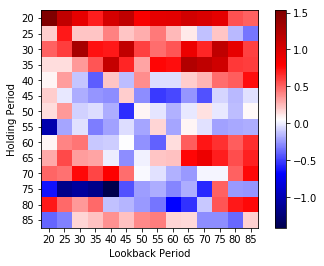

In [39]:
heatmap(ddf)
plt.show()

### References

https://www.quantinsti.com/blog/portfolio-optimization-maximum-return-risk-ratio-python/

https://arxiv.org/pdf/1602.06186.pdf/

https://www.quantinsti.com/blog/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/

https://www.mystockoptions.com/content/what-is-a-lookback

https://www.investopedia.com/terms/s/sharperatio.asp